# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Import Data

In [2]:
# Import data.
loan_data_preprocessed_backup = pd.read_csv('data/loan_data_2007_2014_preprocessed.csv')
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

loan_data_defaults = pd.read_csv('data/loan_data_defaults.csv')

# Explore Data

In [3]:
print(loan_data_preprocessed.shape)
loan_data_preprocessed.head(2)

(466285, 209)


,Unnamed: 0,Unnamed: 0.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0


In [4]:
print(loan_data_defaults.shape)
loan_data_defaults.head(2)

(43236, 213)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,...,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate,CCF,recovery_rate_0_1
0,1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,...,0,0,0,0,1,0,0,0.046832,0.817416,1
1,8,8,8,1071795,1306957,5600,5600,5600.0,60 months,21.28,...,0,0,0,0,1,0,0,0.033761,0.971068,1


# LGD Model

### Splitting Data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# LGD model stage 1 datasets: recovery rate 0 or greater than 0.
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

### Preparing the Inputs

In [7]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']
# List of all independent variables for the models.

In [8]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']
# List of the dummy variable reference categories. 

In [9]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
# Here we keep only the variables we need for the model.

In [10]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

print(lgd_inputs_stage_1_train.shape)

(34588, 44)


In [11]:
lgd_inputs_stage_1_train.isnull().sum()
# Check for missing values. We check whether the value of each row for each column is missing or not,
# then sum accross columns.

grade:A                                0
grade:B                                0
grade:C                                0
grade:D                                0
grade:E                                0
grade:F                                0
home_ownership:MORTGAGE                0
home_ownership:NONE                    0
home_ownership:OTHER                   0
home_ownership:OWN                     0
verification_status:Not Verified       0
verification_status:Source Verified    0
purpose:car                            0
purpose:debt_consolidation             0
purpose:educational                    0
purpose:home_improvement               0
purpose:house                          0
purpose:major_purchase                 0
purpose:medical                        0
purpose:moving                         0
purpose:other                          0
purpose:renewable_energy               0
purpose:small_business                 0
purpose:vacation                       0
purpose:wedding 

### Estimating the Model

### Stage 1

In [12]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        #self.z_scores = z_scores
        self.p_values = p_values
        #self.sigma_estimates = sigma_estimates
        #self.F_ij = F_ij

In [13]:
reg_lgd_st_1 = LogisticRegression_with_p_values()
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

In [14]:
feature_name = lgd_inputs_stage_1_train.columns.values
# Stores the names of the columns of a dataframe in a variable.
print(feature_name)

['grade:A' 'grade:B' 'grade:C' 'grade:D' 'grade:E' 'grade:F'
 'home_ownership:MORTGAGE' 'home_ownership:NONE' 'home_ownership:OTHER'
 'home_ownership:OWN' 'verification_status:Not Verified'
 'verification_status:Source Verified' 'purpose:car'
 'purpose:debt_consolidation' 'purpose:educational'
 'purpose:home_improvement' 'purpose:house' 'purpose:major_purchase'
 'purpose:medical' 'purpose:moving' 'purpose:other'
 'purpose:renewable_energy' 'purpose:small_business' 'purpose:vacation'
 'purpose:wedding' 'initial_list_status:w' 'term_int' 'emp_length_int'
 'mths_since_issue_d' 'mths_since_earliest_cr_line' 'funded_amnt'
 'int_rate' 'installment' 'annual_inc' 'dti' 'delinq_2yrs'
 'inq_last_6mths' 'mths_since_last_delinq' 'mths_since_last_record'
 'open_acc' 'pub_rec' 'total_acc' 'acc_now_delinq' 'total_rev_hi_lim']


In [15]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_lgd_st_1.p_values
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-5.558221e-05,NaN
1,grade:A,-6.795707e-06,9.999356e-01
2,grade:B,-5.294391e-05,9.993798e-01
3,grade:C,-1.123227e-04,9.986388e-01
4,grade:D,2.304027e-05,9.997320e-01
5,grade:E,1.497238e-05,9.998421e-01
6,grade:F,6.745851e-05,9.993811e-01
7,home_ownership:MORTGAGE,-3.149680e-05,9.990085e-01
8,home_ownership:NONE,8.221090e-07,9.999992e-01
9,home_ownership:OTHER,7.256036e-07,9.999985e-01


### Testing the Model

In [16]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
# Here we keep only the variables we need for the model.

In [17]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [18]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [19]:
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [20]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)
# Calculates the predicted probability values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [21]:
y_hat_test_proba_lgd_stage_1
# This is an array of arrays of predicted class probabilities for all classes.
# In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0,
# and the second value is the probability for the observation to belong to the first class, i.e. 1.

array([[0.3907724 , 0.6092276 ],
       [0.38899655, 0.61100345],
       [0.5450988 , 0.4549012 ],
       ...,
       [0.52010829, 0.47989171],
       [0.41123402, 0.58876598],
       [0.45310323, 0.54689677]])

In [22]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
# In other words, we take only the probabilities for being 1.

In [23]:
y_hat_test_proba_lgd_stage_1

array([0.6092276 , 0.61100345, 0.4549012 , ..., 0.47989171, 0.58876598,
       0.54689677])

In [24]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [25]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)
# We reset the index of a dataframe.

In [26]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)
# Concatenates two dataframes.

In [27]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [28]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index
# Makes the index of one dataframe equal to the index of another dataframe.

In [29]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
21362,1,0.609228
8768,1,0.611003
11903,0,0.454901
42973,1,0.547883
29933,0,0.415082


### Estimating the Аccuracy of the Мodel

In [30]:
tr = 0.5
# We create a new column with an indicator,
# where every observation that has predicted probability greater than the threshold has a value of 1,
# and every observation that has predicted probability lower than the threshold has a value of 0.
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [31]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])
# Creates a cross-table where the actual values are displayed by rows and the predicted values by columns.
# This table is known as a Confusion Matrix.

Predicted,0,1
Actual,,
0,998,2764
1,692,4194


In [32]:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]
# Here we divide each value of the table by the total number of observations,
# thus getting percentages, or, rates.

Predicted,0,1
Actual,,
0,0.115402,0.319611
1,0.080019,0.484968


In [33]:
(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# Here we calculate Accuracy of the model, which is the sum of the diagonal rates.

0.6003700277520814

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

In [35]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1,y_hat_test_lgd_stage_1
21362,1,0.609228,1
8768,1,0.611003,1
11903,0,0.454901,0
42973,1,0.547883,1
29933,0,0.415082,0


In [36]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# Returns the Receiver Operating Characteristic (ROC) Curve from a set of actual values and their predicted probabilities.
# As a result, we get three arrays: the false positive rates, the true positive rates, and the thresholds.
# we store each of the three arrays in a separate variable.

Text(0.5, 1.0, 'ROC curve')

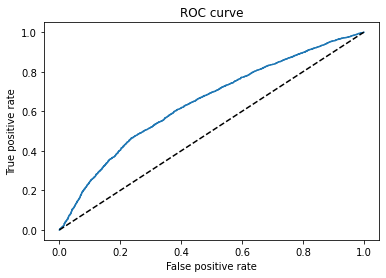

In [37]:
plt.plot(fpr, tpr)
# We plot the false positive rate along the x-axis and the true positive rate along the y-axis,
# thus plotting the ROC curve.
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('False positive rate')
# We name the x-axis "False positive rate".
plt.ylabel('True positive rate')
# We name the x-axis "True positive rate".
plt.title('ROC curve')
# We name the graph "ROC curve".

In [38]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.6453480122986985

### Saving the Model

In [39]:
import pickle

In [40]:
pickle.dump(reg_lgd_st_1, open('models/lgd_model_stage_1.sav', 'wb'))
# Here we export our model to a 'SAV' file with file name 'lgd_model_stage_1.sav'.

### Stage 2 – Linear Regression

In [41]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]
# Here we take only rows where the original recovery rate variable is greater than one,
# i.e. where the indicator variable we created is equal to 1.

In [42]:
# LGD model stage 2 datasets: how much more than 0 is the recovery rate
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [43]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [45]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]
# Here we keep only the variables we need for the model.

In [46]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [47]:
reg_lgd_st_2 = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

LinearRegression()

In [48]:
feature_name = lgd_inputs_stage_2_train.columns.values
# Stores the names of the columns of a dataframe in a variable.

In [49]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_lgd_st_2.p
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values.round(3)
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


### Stage 2 – Linear Regression Evaluation

In [50]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
# Here we keep only the variables we need for the model.

In [51]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [52]:
lgd_inputs_stage_2_test.columns.values
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [53]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [54]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [55]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [56]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


<AxesSubplot:xlabel='recovery_rate', ylabel='Density'>

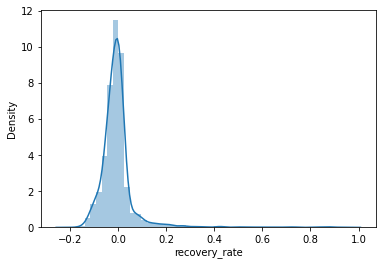

In [57]:
sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)
# We plot the distribution of the residuals.

In [58]:
pickle.dump(reg_lgd_st_2, open('models/lgd_model_stage_2.sav', 'wb'))
# Here we export our model to a 'SAV' file with file name 'lgd_model_stage_1.sav'.

### Combining Stage 1 and Stage 2

In [59]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [60]:
y_hat_test_lgd_stage_2_all

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [61]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all
# Here we combine the predictions of the models from the two stages.

In [62]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.087135
std,0.050119
min,-0.007634
25%,0.063962
50%,0.101121
75%,0.123726
max,0.236973


In [63]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [64]:
pd.DataFrame(y_hat_test_lgd).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.087137
std,0.050115
min,0.000000
25%,0.063962
50%,0.101121
75%,0.123726
max,0.236973


# EAD Model

In [65]:
## Estimation and Interpretation

In [66]:
# EAD model datasets
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [67]:
ead_inputs_train.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'member_id',
       'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc

In [68]:
len(features_all),len(features_reference_cat)

(49, 5)

In [69]:
ead_inputs_train = ead_inputs_train[features_all]
# Here we keep only the variables we need for the model.

In [70]:
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [71]:
reg_ead = LinearRegression()
# We create an instance of an object from the 'LogisticRegression' class.
reg_ead.fit(ead_inputs_train, ead_targets_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

LinearRegression()

In [72]:
feature_name = ead_inputs_train.columns.values

In [73]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
p_values = reg_lgd_st_2.p
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.
p_values = np.append(np.nan,np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,1.970424e-12
5,grade:E,-6.768713e-02,1.918578e-03
6,grade:F,-2.045907e-02,2.748685e-01
7,home_ownership:MORTGAGE,-6.343341e-03,6.050271e-02
8,home_ownership:NONE,-5.539064e-03,9.092582e-05
9,home_ownership:OTHER,-2.426052e-03,6.436926e-01


## Model Validation

In [74]:
ead_inputs_test = ead_inputs_test[features_all]
# Here we keep only the variables we need for the model.

In [75]:
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [76]:
ead_inputs_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [77]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [78]:
ead_targets_test_temp = ead_targets_test

In [79]:
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [80]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


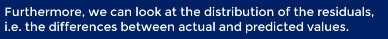

<AxesSubplot:xlabel='CCF', ylabel='Density'>

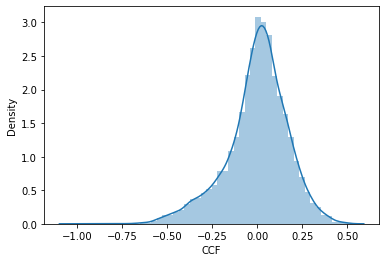

In [81]:
sns.distplot(ead_targets_test - y_hat_test_ead)
# We plot the distribution of the residuals.

In [82]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [83]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
# We set predicted values that are greater than 1 to 1 and predicted values that are less than 0 to 0.

In [84]:
pd.DataFrame(y_hat_test_ead).describe()
# Shows some descriptive statisics for the values of a column.

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


In [85]:
pickle.dump(reg_ead, open('models/reg_ead.sav', 'wb'))